In [1]:
# Useful starting lines
%matplotlib inline

import numpy as np
import scipy
import scipy.io
import scipy.sparse as sp
import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2

## Load the Data
Note that `ratings` is a sparse matrix that in the shape of (num_items, num_users)

In [2]:
from helpers import load_data, preprocess_data

path_dataset = "data/data_train.csv"
ratings = load_data(path_dataset)

number of items: 10000, number of users: 1000


In [15]:
print(ratings.shape)

(10000, 1000)


### Plot the number of ratings per movie and user

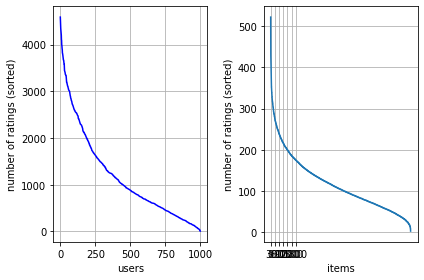

min # of items per user = 8, min # of users per item = 3.


In [3]:
from plots import plot_raw_data

num_items_per_user, num_users_per_item = plot_raw_data(ratings)

print("min # of items per user = {}, min # of users per item = {}.".format(
        min(num_items_per_user), min(num_users_per_item)))

### Split the data into a train and test set

In [4]:
def split_data(ratings, num_items_per_user, num_users_per_item,
               min_num_ratings, p_test=0.1):
    """split the ratings to training data and test data.
    Args:
        min_num_ratings: 
            all users and items we keep must have at least min_num_ratings per user and per item. 
    """
    # set seed
    np.random.seed(988)
    
    # select user and item based on the condition.
    valid_users = np.where(num_items_per_user >= 1)[0]   #return only when it's true
    valid_items = np.where(num_users_per_item >= 1)[0]   
    valid_ratings = ratings[valid_items, :][: , valid_users]  #Why not directly [valid_items,valid_users] ?  
    
    # ***************************************************
    # split the data and return train and test data. 
    num_rows, num_cols = valid_ratings.shape
    train = sp.lil_matrix((num_rows, num_cols))
    test = sp.lil_matrix((num_rows, num_cols))
    
    index = valid_ratings.nonzero()  #tuple of array 

    order_shuffled = np.arange(0,len(index[0]))
    np.random.shuffle(order_shuffled)
     
    index_shuffled = (index[0][order_shuffled],index[1][order_shuffled])

    test_index_size = int(p_test*len(order_shuffled))
    
    index_test = (index_shuffled[0][:test_index_size],index_shuffled[1][:test_index_size])
  
    index_train = (index_shuffled[0][test_index_size:],index_shuffled[1][test_index_size:])

    test[index_test] =  valid_ratings[index_test]
    
    train[index_train] = valid_ratings[index_train]
    print("Total number of nonzero elements in origial data:{v}".format(v=ratings.nnz))
    print("Total number of nonzero elements in valid data:{v}".format(v=valid_ratings.nnz))
    print("Total number of nonzero elements in train data:{v}".format(v=train.nnz))
    print("Total number of nonzero elements in test data:{v}".format(v=test.nnz))
    return valid_ratings, train, test

Total number of nonzero elements in origial data:1176952
Total number of nonzero elements in valid data:1176952
Total number of nonzero elements in train data:1059257
Total number of nonzero elements in test data:117695


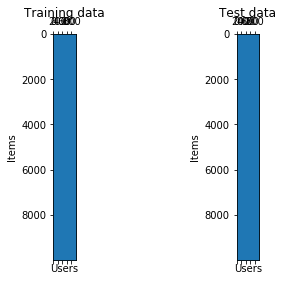

In [5]:
from plots import plot_train_test_data

valid_ratings, train, test = split_data(
    ratings, num_items_per_user, num_users_per_item, min_num_ratings=10, p_test=0.1)
plot_train_test_data(train, test)

## Implementing Baselines 

### Use the global mean to do the prediction

In [16]:
from helpers import calculate_mse

def baseline_global_mean(train, test):
    """baseline method: use the global mean."""
    
    global_mean_train = train[train.nonzero()].mean()
    
    test_nonzero_dense = test[test.nonzero()].todense()
    
    mse = calculate_mse( test_nonzero_dense, global_mean_train )
    
    rmse = np.sqrt( mse / test_nonzero_dense.shape[1] )
    
    print("Baseline RMSE on test: ", rmse[0,0])
    
    return global_mean_train
    
baseline_global_mean(train, test)

Baseline RMSE on test:  1.1218526668314277


3.8579126689158105

### Use the user means as the prediction

In [20]:
def baseline_user_mean(train, test):
    """baseline method: use the user means as the prediction."""
    mse = 0
    count = 0 
    num_items, num_users = train.shape
    
    sums=train.sum(axis=0) #sum for each user
    
    mean_user=np.zeros((1,num_users))


    for j in range(0,num_users):
        if(sums[0,j] != 0):
            elems = train[:,j]
            elems_nonzero = elems[elems.nonzero()]
            mean_user[0,j] = elems_nonzero.mean()
    
        for i in range(test.shape[0]):
            if(test[i,j] != 0):
                mean_user_elem = mean_user[0,j]
                mse += (test[i,j]-mean_user_elem )**2
                count+= 1
    rmse = np.sqrt( mse / count )
    print("Baseline User RMSE on test: ",rmse)
    return mean_user
baseline_user_mean(train, test)

KeyboardInterrupt: 

### Use the item means as the prediction

In [ ]:
def baseline_item_mean(train, test):
    """baseline method: use item means as the prediction."""
    mse = 0
    count = 0 
    num_items, num_users = train.shape
    
    sums=train.sum(axis=1) #sum for each user
    
    mean_item=np.zeros((num_items,1))

    for i in range(0,num_items):
        if(sums[i,0] != 0):
            elems = train[i,:]
            elems_nonzero = elems[elems.nonzero()]
            mean_item[i,0] = elems_nonzero.mean()
    
        for j in range(test.shape[1]):
            if(test[i,j] != 0):
                mean_item_elem = mean_item[i,0]
                mse += (test[i,j]-mean_item_elem)**2
                count+= 1
   
    rmse = np.sqrt( mse / count )
    
    return rmse
baseline_item_mean(train, test)

The **item mean prediction** gives us the best approximation 

### Learn the Matrix Factorization using SGD

#### Initialize matrix factorization

In [6]:
def init_MF(train, num_features):
    """init the parameter for matrix factorization."""

    num_items, num_users = train.shape
    user_features = np.random.rand(num_features,num_users)/num_users
    user_features[0,:]=np.ones((num_users,))
    item_features = np.random.rand(num_features,num_items)/num_items
    item_features[0,:]=sp.csr_matrix.mean(train,axis=1).reshape(num_items,)

    return user_features, item_features

Compute the cost by the method of matrix factorization.


In [7]:
def compute_error(data, user_features, item_features, nz):
    """compute the loss (MSE) of the prediction of nonzero elements."""
    mse=0
    for row,col in nz:
        w_d = item_features[:,row]
        z_n = user_features[:,col]
        prediction= w_d @ z_n.T
        error_prediction = (data[row,col] - prediction ) **2 
        mse+=error_prediction
    
    return np.sqrt(mse / len(nz))

In [8]:
def matrix_factorization_SGD(train, test,reg=True):
    """matrix factorization by SGD."""
    # define parameters
    gamma = 0.025
    num_features = 20   # K in the lecture notes
    lambda_user = 0.1
    lambda_item = 0.01
    num_epochs = 20     # number of full passes through the train set
    errors = [0]
    
    # set seed
    np.random.seed(988)

    # init matrix
    user_features, item_features = init_MF(train, num_features)   #Z0.T,W0
    
    # find the non-zero ratings indices 
    nz_row, nz_col = train.nonzero()
    nz_train = list(zip(nz_row, nz_col))
    nz_row, nz_col = test.nonzero()
    nz_test = list(zip(nz_row, nz_col))

    print("learn the matrix factorization using SGD...")
    for it in range(num_epochs):        
        # shuffle the training rating indices
        np.random.shuffle(nz_train)
        
        # decrease step size
        gamma /= 1.2
        
        for d, n in nz_train:
            
            item_data = item_features[:,d]  
            user_data = user_features[:,n]
            prediction = item_data @ user_data.T
    
            prediciton_error = train[d, n] - item_data @ user_data.T
        
            #compute derivative wrt w
            grad_w = -prediciton_error * user_data  
                
            #compute derivative wrt z 
            grad_z = -prediciton_error * item_data
   
            #update 
            if(reg):  
                item_features[:,d]-= gamma * ( grad_w + lambda_item * item_data)
                user_features[:,n]-= gamma * ( grad_z + lambda_user * user_data)
            
            else:
                item_features[:,d]-= gamma * grad_w
                user_features[:,n]-= gamma * grad_z
        
        rmse = compute_error(train, user_features, item_features, nz_train)
        print("iter: {}, RMSE on training set: {}.".format(it, rmse))
        
        errors.append(rmse)

    rmse = compute_error(test, user_features, item_features, nz_test)
    print("RMSE on test data: {}.".format(rmse))
    
    return user_features, item_features

# Prediction 

In [9]:
user, movie = matrix_factorization_SGD(train, test)

learn the matrix factorization using SGD...
iter: 0, RMSE on training set: 1.0341250818940566.
iter: 1, RMSE on training set: 1.0267911758154897.
iter: 2, RMSE on training set: 1.021062716900459.
iter: 3, RMSE on training set: 1.015999990030333.
iter: 4, RMSE on training set: 1.0082054972902539.
iter: 5, RMSE on training set: 1.006680078274515.
iter: 6, RMSE on training set: 1.003776307290016.
iter: 7, RMSE on training set: 1.0011289802515346.
iter: 8, RMSE on training set: 0.9996917013478903.
iter: 9, RMSE on training set: 0.9987719715433111.
iter: 10, RMSE on training set: 0.9976102638023375.
iter: 11, RMSE on training set: 0.9966244557320055.
iter: 12, RMSE on training set: 0.9962871918753649.
iter: 13, RMSE on training set: 0.9945629371453754.
iter: 14, RMSE on training set: 0.9945231619998325.
iter: 15, RMSE on training set: 0.9940944020566117.
iter: 16, RMSE on training set: 0.9931699855622435.
iter: 17, RMSE on training set: 0.9927786573439222.
iter: 18, RMSE on training set: 0.

In [11]:
import utils as u 
data=u.read_txt("data/sampleSubmission.csv")
test_indices= u.predict_on_model_line(data[1:])  

preds=[]
ids=[]
acc=0

for iid,uid in test_indices: #(row,col) => (movie,user)
    acc=acc+1
        
    item_data = movie[:,iid]  
    user_data = user[:,uid]
            
    prediciton= item_data @ user_data.T
    
    ids.append("r{0}_c{1}".format(iid+1,uid+1))
    preds.append(max(1,min(5,int(round(prediciton)))))
    
u.create_csv_submission(ids, preds, "submissionRemontada_SGD.csv")
#1.043 online

### Learn the Matrix Factorization using Alternating Least Squares

In [241]:
def update_user_feature(
        train, item_features, lambda_user,
        nnz_items_per_user, nz_user_itemindices):
    """update user feature matrix."""
    """the best lambda is assumed to be nnz_items_per_user[user] * lambda_user"""
    
    
    num_user = nnz_items_per_user.shape[0]
    num_feature = item_features.shape[0]
    lambda_I = lambda_user * np.eye(num_feature)
    updated_user_features = np.zeros((num_feature, num_user))

    for user, items in nz_user_itemindices:
        # extract the columns corresponding to the prediction for given item
        M = item_features[:, items]
        
        # update column row of user features
        V = M @ train[items, user]
        A = M @ M.T + nnz_items_per_user[user] * lambda_I
        X = np.linalg.solve(A, V)
        updated_user_features[:, user] = np.copy(X.T)
    return updated_user_features

def update_item_feature(
        train, user_features, lambda_item,
        nnz_users_per_item, nz_item_userindices):
    """update item feature matrix."""
    """the best lambda is assumed to be nnz_items_per_item[item] * lambda_item"""
    num_item = nnz_users_per_item.shape[0]
    num_feature = user_features.shape[0]
    lambda_I = lambda_item * sp.eye(num_feature)
    updated_item_features = np.zeros((num_feature, num_item))

    for item, users in nz_item_userindices:
        # extract the columns corresponding to the prediction for given user
        M = user_features[:, users]
        V = M @ train[item, users].T
        A = M @ M.T + nnz_users_per_item[item] * lambda_I
        X = np.linalg.solve(A, V)
        updated_item_features[:, item] = np.copy(X.T)
    return updated_item_features

In [246]:
from helpers import build_index_groups


def ALS(train, test):
    """Alternating Least Squares (ALS) algorithm."""
    # define parameters
    num_features = 20   # K in the lecture notes
    lambda_user = 0.081
    lambda_item = 0.081
    stop_criterion = 1e-5
    change = 1
    error_list = [0, 0]
    
    # set seed
    np.random.seed(988)

    # init ALS
    user_features, item_features = init_MF(train, num_features)
    
    # get the number of non-zero ratings for each user and item
    nnz_items_per_user, nnz_users_per_item = train.getnnz(axis=0), train.getnnz(axis=1)

    # group the indices by row or column index
    nz_train, nz_item_userindices, nz_user_itemindices = build_index_groups(train)

    # run ALS
    print("\nstart the ALS algorithm...")
    while change > stop_criterion:
        # update user feature & item feature
        user_features = update_user_feature(
            train, item_features, lambda_user,
            nnz_items_per_user, nz_user_itemindices)
        item_features = update_item_feature(
            train, user_features, lambda_item,
            nnz_users_per_item, nz_item_userindices)

        error = compute_error(train, user_features, item_features, nz_train)
        print("RMSE on training set: {}.".format(error))
        error_list.append(error)
        change = np.fabs(error_list[-1] - error_list[-2])

    # evaluate the test error
    nnz_row, nnz_col = test.nonzero()
    nnz_test = list(zip(nnz_row, nnz_col))
    rmse = compute_error(test, user_features, item_features, nnz_test)
    print("test RMSE after running ALS: {v}.".format(v=rmse))
    return user_features, item_features

In [247]:
user_als, item_als = ALS(train, test)


start the ALS algorithm...
RMSE on training set: 1.0152593560249021.
RMSE on training set: 0.9904249347165527.
RMSE on training set: 0.9904844858040318.
RMSE on training set: 0.9905382682464379.
RMSE on training set: 0.9903089659056613.
RMSE on training set: 0.986260515318704.
RMSE on training set: 0.9737543239367028.
RMSE on training set: 0.9609668308089243.
RMSE on training set: 0.9521454783968171.
RMSE on training set: 0.9400591576512695.
RMSE on training set: 0.9268963299326353.
RMSE on training set: 0.9125408406327339.
RMSE on training set: 0.9009753328166344.
RMSE on training set: 0.8947295540198656.
RMSE on training set: 0.8921498514354687.
RMSE on training set: 0.8911024416353106.
RMSE on training set: 0.8905940150138085.
RMSE on training set: 0.8902957705137557.
RMSE on training set: 0.8901002382325935.
RMSE on training set: 0.8899652670547992.
RMSE on training set: 0.8898702940376921.
RMSE on training set: 0.8898034542674668.
RMSE on training set: 0.889757115592838.
RMSE on 

In [248]:
import utils as u 
data=u.read_txt("data/sampleSubmission.csv")
test_indices= u.predict_on_model_line(data[1:])  

preds=[]
ids=[]
acc=0

for iid,uid in test_indices: #(row,col) => (movie,user)
    acc=acc+1
        
    item_data = item_als[:,iid]  
    user_data = user_als[:,uid]
            
    prediciton= item_data @ user_data.T
    
    ids.append("r{0}_c{1}".format(iid+1,uid+1))
    preds.append(max(1,min(5,int(round(prediciton)))))

u.create_csv_submission(ids, preds, "submissionRemontada_ALS_improved.csv")

RMSE of 1.028